In [32]:
import os
import numpy as np
import tensorflow as tf
import matplotlib as plt
import h5py
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [23]:
os.getcwd()

'/home/vividlee/Desktop/YeloCar'

In [24]:
os.getcwd()
os.chdir('/home/vividlee/Desktop/YeloCar/HDF5/deep4pc_test5/')

hdf5_files = os.listdir()
print(hdf5_files)

['dataset_hsv_deep4pc_test4_all.hdf5', 'dataset_hsv_01.hdf5']


In [25]:
os.getcwd()

'/home/vividlee/Desktop/YeloCar/HDF5/deep4pc_test5'

In [26]:
# downloading KHG0data

# existing-data : dataset_hsv_deep4pc_test4_all.hdf5
# KHG-data : dataset_hsv_01.hdf5
# merged data including 'existing-data+KHG-data'

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
        
test_name = 'test5_'
merged_data = 'existing-data+KHG-data'

image_train = None
action_train = None
image_val = None
action_val = None
    
for hdf5_file in hdf5_files :
    print(hdf5_file)
    
    with h5py.File('./' + hdf5_file, 'r') as hf :
        if image_train is None:
            image_train = np.array(hf['x_train'][:, :, :, :])
            action_train = np.array(hf['y_train'][:, :])
            image_val = np.array(hf['x_val'][:, :, :, :])
            action_val = np.array(hf['y_val'][:, :])
        else:
            image_train = np.concatenate((image_train, hf['x_train']), axis=0)
            action_train = np.concatenate((action_train, hf['y_train']), axis=0)
            image_val = np.concatenate((image_val, hf['x_val']), axis=0)
            action_val = np.concatenate((action_val, hf['y_val']), axis=0)

train_len = len(image_train)
val_len = len(image_val)

os.chdir('/home/vividlee/Desktop/YeloCar')
os.getcwd()

model_directory = 'Model_' + test_name + merged_data
createFolder('./Model/' + model_directory)
 
with h5py.File('./Model/' + model_directory + '/dataset_hsv_' + test_name + merged_data + '.hdf5', 'w') as hf:
    print("write in /Model/"  + model_directory + "/dataset_hsv_" + test_name +  merged_data + ".hdf5\n")
    dset_x_train = hf.create_dataset('x_train', (train_len, 48, 64, 3), chunks=True, compression="gzip")
    dset_y_train = hf.create_dataset('y_train', (train_len, 2), chunks=True, compression="gzip")
    dset_x_val = hf.create_dataset('x_val', (val_len, 48, 64, 3), chunks=True, compression="gzip")
    dset_y_val = hf.create_dataset('y_val', (val_len, 2), chunks=True, compression="gzip")

    dset_x_train[:, :, :, :] = image_train
    dset_y_train[:, :] = action_train
    dset_x_val[:, :, :, :] = image_val
    dset_y_val[:, :] = action_val

dataset_hsv_deep4pc_test4_all.hdf5
dataset_hsv_01.hdf5
write in /Model/Model_test5_existing-data+KHG-data/dataset_hsv_test5_existing-data+KHG-data.hdf5



In [27]:
os.chdir('/home/vividlee/Desktop/YeloCar')
os.getcwd()

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

dataset_version = 'deep4pc_test5'
model_version = 'model_' + '1_p5'

# createFolder('./Test/' + model_version)

with h5py.File('./Model/Model_test5_existing-data+KHG-data/dataset_hsv_test5_existing-data+KHG-data.hdf5', 'r') as hf:
    image_train = np.array(hf['x_train'][:, :, :, :])
    action_train = np.array(hf['y_train'][:, :])
    image_val = np.array(hf['x_val'][:, :, :, :])
    action_val = np.array(hf['y_val'][:, :])
    
    
(x_train, y_train), (x_test, y_test) = (image_train, action_train), (image_val, action_val)

x_train /= 255.
x_test /= 255.

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(48, 64, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)
])

optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse'])

model.summary()

model_path = './Model/Model_test5_existing-data+KHG-data' + '/' + model_version + '_{epoch:02d}_{loss:.4f}_{val_mae:.4f}'

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_mae', verbose=1, save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)

history = model.fit(x=x_train, y=y_train, batch_size=256, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stopping_callback, checkpointer])

print("\n")
print(model.evaluate(x_test, y_test))

# outputs = model(x_test[0:20])

# print(outputs)

# f = open('./Test/' + model_version + '/' + model_version + '_test.txt', 'a')
# f.write("{}".format(outputs))

# x_test *= 255
    
# for i in range (0, 20) :
#     cv2.imwrite('./Test/' + model_version + '/'+ model_path + '_' + str(i) + '.jpeg', x_test[i])

# plotting
# trainset : blue, line
# testset : red, dot_line


2022-02-21 16:22:06.419153: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vividlee/anaconda3/envs/py38/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-21 16:22:06.419249: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vividlee/anaconda3/envs/py38/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-21 16:22:06.419324: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vividlee/anaconda3/envs/py38/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-21 16:22:06.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 12, 32)         9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 6, 32)         0

2022-02-21 16:24:58.868980: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Model/Model_test5_existing-data+KHG-data/model_1_p5_01_0.0599_0.0664/assets
1004/1004 [==============================] - 169s 167ms/step - loss: 0.0599 - mae: 0.0599 - mse: 0.0096 - val_loss: 0.0664 - val_mae: 0.0664 - val_mse: 0.0107
Epoch 2/100
1004/1004 [==============================] - ETA: 0s - loss: 0.0509 - mae: 0.0509 - mse: 0.0078
Epoch 00002: val_mae improved from 0.06644 to 0.06590, saving model to ./Model/Model_test5_existing-data+KHG-data/model_1_p5_02_0.0509_0.0659
INFO:tensorflow:Assets written to: ./Model/Model_test5_existing-data+KHG-data/model_1_p5_02_0.0509_0.0659/assets
1004/1004 [==============================] - 167s 166ms/step - loss: 0.0509 - mae: 0.0509 - mse: 0.0078 - val_loss: 0.0659 - val_mae: 0.0659 - val_mse: 0.0106
Epoch 3/100
1004/1004 [==============================] - ETA: 0s - loss: 0.0489 - mae: 0.0489 - mse: 0.0074
Epoch 00003: val_mae improved from 0.06590 to 0.06547, saving model to ./Model/Model_test5_existin

NameError: name 'numpy' is not defined

[0.06644020974636078, 0.06590058654546738, 0.06546829640865326, 0.06431181728839874, 0.06523092091083527, 0.06465049088001251, 0.06532075256109238, 0.06532999128103256, 0.06547509133815765, 0.06517685949802399, 0.06435021013021469, 0.06510477513074875, 0.06665048748254776, 0.06490464508533478]


[0.05993957072496414, 0.05088336393237114, 0.04892105236649513, 0.04760449752211571, 0.046500492841005325, 0.045623794198036194, 0.04482612758874893, 0.044140271842479706, 0.0434737503528595, 0.042932868003845215, 0.042483504861593246, 0.042019087821245193, 0.04163806140422821, 0.04120723158121109]


[0.06644020974636078, 0.06590058654546738, 0.06546829640865326, 0.06431181728839874, 0.06523092091083527, 0.06465049088001251, 0.06532075256109238, 0.06532999128103256, 0.06547509133815765, 0.06517685949802399, 0.06435021013021469, 0.06510477513074875, 0.06665048748254776, 0.06490464508533478]


[0.05993957072496414, 0.05088336393237114, 0.04892105236649513, 0.04760449752211571, 0.04650049284100532

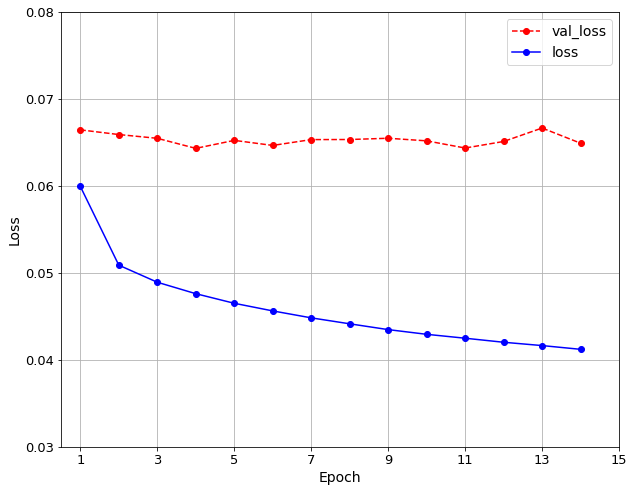

<function matplotlib.pyplot.show(close=None, block=None)>

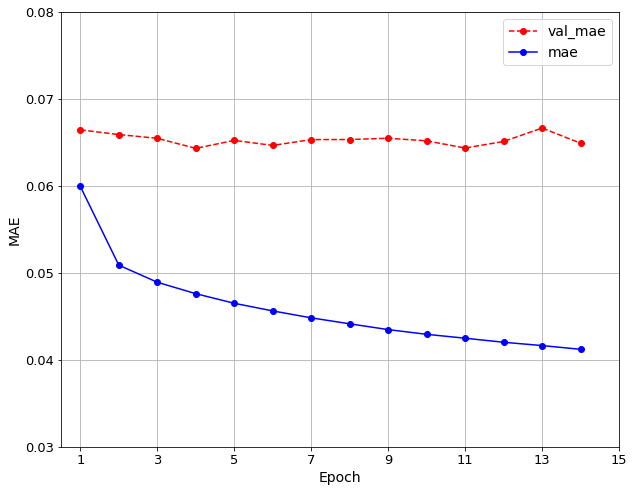

In [38]:
y_vloss = history.history['val_loss']   # testset
y_loss = history.history['loss']        # trainset
print(y_vloss)
print('\n')
print(y_loss)
print('\n')
y_vmae = history.history['val_mae']
y_mae = history.history['mae']
print(y_vmae)
print('\n')
print(y_mae)
print('\n')
x_len = np.arange(len(y_loss))
print(len(y_loss))
print('\n')

plt.figure(figsize=(10, 8))
plt.plot(x_len+1, y_vloss, 'ro--', label='val_loss')
plt.plot(x_len+1, y_loss, 'bo-', label='loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.xlim([0.5, len(y_loss)+0.5])
plt.ylim([0.03, 0.08])
plt.xticks([1, 3, 5, 7, 9, 11, 13, 15],fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(x_len+1, y_vmae, 'ro--', label='val_mae')
plt.plot(x_len+1, y_mae, 'bo-', label='mae')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.xlim([0.5, len(y_loss)+0.5])
plt.ylim([0.03, 0.08])
plt.xticks([1, 3, 5, 7, 9, 11, 13, 15], fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show